In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis
from itertools import combinations

In [3]:
livetime = 2 * u.h
n_obs = 500
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [5]:
model_simu = PowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
print(model_simu)
model = [] 
mod = SkyModel(spectral_model=model_simu)
model.append(mod)

PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True


In [6]:
l = [0.01,0.1,0.2,0.3,0.5,1,2,3,5]
simu = []
for i in range(9):
    sim = ExpCutoffPowerLawSpectralModel(
        index=2.22,
        amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
        reference=1 * u.TeV,
        lambda_=l[i] * u.Unit("TeV-1"),
        alpha = 1,
    )
    mod = SkyModel(spectral_model=sim)
    simu.append(sim)
    model.append(mod)
    print(model[i+1])
    print(simu[i])

SkyModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
SkyModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  Fa

In [7]:
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [8]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 7200.0 s



In [9]:
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [10]:
data = []
for i in range(len(model)):
    dataset.model = model[i]
    dataset.fake(random_state=42)
    print(dataset)
    data.append(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 836 
    Total predicted counts          : nan
    Total background counts         : 846.23

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 7.20e+03 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0


SpectrumDataset

    Name                            : 1 

    Total counts                    : 836 
    Total predicted counts          : nan
    Total background counts         : 846.23

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 7.20e+03 s

    Number of total bins            : 9 
    Number of fit bins    

In [11]:
data_onoff = []
for i in range(len(model)):
    dataset_onoff = SpectrumDatasetOnOff(
        aeff=dataset.aeff,
        edisp=dataset.edisp,
        models=model[i],
        livetime=livetime,
        acceptance=1,
        acceptance_off=5,
    )
    dataset_onoff.fake(background_model=dataset.background)
    print(dataset_onoff)
    data_onoff.append(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 1543 
    Total predicted counts          : 1554.65
    Total off counts                : 4247.00

    Total background counts         : 849.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.42

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 1596 
    Total predicted counts          : 1539.01
    Total off counts                : 4214.00

    Total background counts         : 842.80

    Effective 

In [12]:
%%time
datas = []
for i in range(len(model)):
    datasets = []
    for idx in range(n_obs):
        data_onoff[i].fake(random_state=idx, background_model=dataset.background)
        data_onoff[i].name = f"obs_{idx}"
        datasets.append(data_onoff[i].copy())
    datas.append(datasets)

CPU times: user 30.2 s, sys: 246 ms, total: 30.4 s
Wall time: 36.3 s


In [13]:
len(datas)
print(*datas[0], sep = "\n")

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 1623 
    Total predicted counts          : 1548.05
    Total off counts                : 4214.00

    Total background counts         : 842.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.12

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 1505 
    Total predicted counts          : 1541.45
    Total off counts                : 4181.00

    Total background counts         : 836.20

   

SpectrumDatasetOnOff

    Name                            : obs_11 

    Total counts                    : 1559 
    Total predicted counts          : 1567.05
    Total off counts                : 4309.00

    Total background counts         : 861.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.46

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_12 

    Total counts                    : 1579 
    Total predicted counts          : 1554.65
    Total off counts                : 4247.00

    Total background counts         : 849.40

  

SpectrumDatasetOnOff

    Name                            : obs_23 

    Total counts                    : 1588 
    Total predicted counts          : 1550.05
    Total off counts                : 4224.00

    Total background counts         : 844.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.61

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_24 

    Total counts                    : 1536 
    Total predicted counts          : 1576.45
    Total off counts                : 4356.00

    Total background counts         : 871.20

 

SpectrumDatasetOnOff

    Name                            : obs_38 

    Total counts                    : 1587 
    Total predicted counts          : 1547.25
    Total off counts                : 4210.00

    Total background counts         : 842.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.00

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_39 

    Total counts                    : 1600 
    Total predicted counts          : 1563.65
    Total off counts                : 4292.00

    Total background counts         : 858.40

 

SpectrumDatasetOnOff

    Name                            : obs_53 

    Total counts                    : 1571 
    Total predicted counts          : 1557.25
    Total off counts                : 4260.00

    Total background counts         : 852.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.25

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_54 

    Total counts                    : 1555 
    Total predicted counts          : 1552.25
    Total off counts                : 4235.00

    Total background counts         : 847.00

 


SpectrumDatasetOnOff

    Name                            : obs_65 

    Total counts                    : 1520 
    Total predicted counts          : 1530.65
    Total off counts                : 4127.00

    Total background counts         : 825.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.65

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_66 

    Total counts                    : 1470 
    Total predicted counts          : 1541.45
    Total off counts                : 4181.00

    Total background counts         : 836.20

 

SpectrumDatasetOnOff

    Name                            : obs_77 

    Total counts                    : 1540 
    Total predicted counts          : 1550.25
    Total off counts                : 4225.00

    Total background counts         : 845.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.85

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_78 

    Total counts                    : 1526 
    Total predicted counts          : 1555.25
    Total off counts                : 4250.00

    Total background counts         : 850.00

  

SpectrumDatasetOnOff

    Name                            : obs_88 

    Total counts                    : 1572 
    Total predicted counts          : 1530.85
    Total off counts                : 4128.00

    Total background counts         : 825.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.64

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_89 

    Total counts                    : 1525 
    Total predicted counts          : 1546.45
    Total off counts                : 4206.00

    Total background counts         : 841.20

 

SpectrumDatasetOnOff

    Name                            : obs_99 

    Total counts                    : 1563 
    Total predicted counts          : 1548.45
    Total off counts                : 4216.00

    Total background counts         : 843.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.99

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_100 

    Total counts                    : 1532 
    Total predicted counts          : 1564.65
    Total off counts                : 4297.00

    Total background counts         : 859.40

 

SpectrumDatasetOnOff

    Name                            : obs_110 

    Total counts                    : 1515 
    Total predicted counts          : 1555.65
    Total off counts                : 4252.00

    Total background counts         : 850.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.30

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_111 

    Total counts                    : 1529 
    Total predicted counts          : 1509.05
    Total off counts                : 4019.00

    Total background counts         : 803.80


SpectrumDatasetOnOff

    Name                            : obs_124 

    Total counts                    : 1511 
    Total predicted counts          : 1550.25
    Total off counts                : 4225.00

    Total background counts         : 845.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.52

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_125 

    Total counts                    : 1540 
    Total predicted counts          : 1531.05
    Total off counts                : 4129.00

    Total background counts         : 825.80



SpectrumDatasetOnOff

    Name                            : obs_135 

    Total counts                    : 1540 
    Total predicted counts          : 1561.65
    Total off counts                : 4282.00

    Total background counts         : 856.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.44

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_136 

    Total counts                    : 1481 
    Total predicted counts          : 1561.05
    Total off counts                : 4279.00

    Total background counts         : 855.80



SpectrumDatasetOnOff

    Name                            : obs_149 

    Total counts                    : 1582 
    Total predicted counts          : 1534.65
    Total off counts                : 4147.00

    Total background counts         : 829.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.75

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_150 

    Total counts                    : 1565 
    Total predicted counts          : 1554.05
    Total off counts                : 4244.00

    Total background counts         : 848.80



SpectrumDatasetOnOff

    Name                            : obs_163 

    Total counts                    : 1570 
    Total predicted counts          : 1559.45
    Total off counts                : 4271.00

    Total background counts         : 854.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.07

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_164 

    Total counts                    : 1534 
    Total predicted counts          : 1559.05
    Total off counts                : 4269.00

    Total background counts         : 853.80



SpectrumDatasetOnOff

    Name                            : obs_174 

    Total counts                    : 1606 
    Total predicted counts          : 1529.65
    Total off counts                : 4122.00

    Total background counts         : 824.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.07

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_175 

    Total counts                    : 1595 
    Total predicted counts          : 1533.05
    Total off counts                : 4139.00

    Total background counts         : 827.80


SpectrumDatasetOnOff

    Name                            : obs_187 

    Total counts                    : 1559 
    Total predicted counts          : 1543.05
    Total off counts                : 4189.00

    Total background counts         : 837.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.51

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_188 

    Total counts                    : 1505 
    Total predicted counts          : 1579.05
    Total off counts                : 4369.00

    Total background counts         : 873.80


SpectrumDatasetOnOff

    Name                            : obs_198 

    Total counts                    : 1557 
    Total predicted counts          : 1555.25
    Total off counts                : 4250.00

    Total background counts         : 850.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.86

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_199 

    Total counts                    : 1583 
    Total predicted counts          : 1555.85
    Total off counts                : 4253.00

    Total background counts         : 850.60



SpectrumDatasetOnOff

    Name                            : obs_215 

    Total counts                    : 1548 
    Total predicted counts          : 1536.25
    Total off counts                : 4155.00

    Total background counts         : 831.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.50

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_216 

    Total counts                    : 1540 
    Total predicted counts          : 1546.85
    Total off counts                : 4208.00

    Total background counts         : 841.60



SpectrumDatasetOnOff

    Name                            : obs_233 

    Total counts                    : 1503 
    Total predicted counts          : 1568.65
    Total off counts                : 4317.00

    Total background counts         : 863.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.46

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_234 

    Total counts                    : 1606 
    Total predicted counts          : 1575.65
    Total off counts                : 4352.00

    Total background counts         : 870.40



SpectrumDatasetOnOff

    Name                            : obs_245 

    Total counts                    : 1566 
    Total predicted counts          : 1580.45
    Total off counts                : 4376.00

    Total background counts         : 875.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.13

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_246 

    Total counts                    : 1508 
    Total predicted counts          : 1567.85
    Total off counts                : 4313.00

    Total background counts         : 862.60



SpectrumDatasetOnOff

    Name                            : obs_265 

    Total counts                    : 1589 
    Total predicted counts          : 1544.25
    Total off counts                : 4195.00

    Total background counts         : 839.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.64

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_266 

    Total counts                    : 1562 
    Total predicted counts          : 1548.25
    Total off counts                : 4215.00

    Total background counts         : 843.00


SpectrumDatasetOnOff

    Name                            : obs_277 

    Total counts                    : 1555 
    Total predicted counts          : 1563.45
    Total off counts                : 4291.00

    Total background counts         : 858.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.23

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_278 

    Total counts                    : 1613 
    Total predicted counts          : 1548.85
    Total off counts                : 4218.00

    Total background counts         : 843.60



SpectrumDatasetOnOff

    Name                            : obs_291 

    Total counts                    : 1544 
    Total predicted counts          : 1555.25
    Total off counts                : 4250.00

    Total background counts         : 850.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.16

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_292 

    Total counts                    : 1563 
    Total predicted counts          : 1535.65
    Total off counts                : 4152.00

    Total background counts         : 830.40



SpectrumDatasetOnOff

    Name                            : obs_302 

    Total counts                    : 1536 
    Total predicted counts          : 1563.85
    Total off counts                : 4293.00

    Total background counts         : 858.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.34

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_303 

    Total counts                    : 1538 
    Total predicted counts          : 1572.05
    Total off counts                : 4334.00

    Total background counts         : 866.80



SpectrumDatasetOnOff

    Name                            : obs_314 

    Total counts                    : 1607 
    Total predicted counts          : 1528.45
    Total off counts                : 4116.00

    Total background counts         : 823.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.55

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_315 

    Total counts                    : 1549 
    Total predicted counts          : 1556.65
    Total off counts                : 4257.00

    Total background counts         : 851.40


SpectrumDatasetOnOff

    Name                            : obs_328 

    Total counts                    : 1596 
    Total predicted counts          : 1564.45
    Total off counts                : 4296.00

    Total background counts         : 859.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.27

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_329 

    Total counts                    : 1530 
    Total predicted counts          : 1537.65
    Total off counts                : 4162.00

    Total background counts         : 832.40




SpectrumDatasetOnOff

    Name                            : obs_339 

    Total counts                    : 1560 
    Total predicted counts          : 1543.05
    Total off counts                : 4189.00

    Total background counts         : 837.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.94

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_340 

    Total counts                    : 1483 
    Total predicted counts          : 1554.05
    Total off counts                : 4244.00

    Total background counts         : 848.80

SpectrumDatasetOnOff

    Name                            : obs_357 

    Total counts                    : 1594 
    Total predicted counts          : 1539.05
    Total off counts                : 4169.00

    Total background counts         : 833.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.07

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_358 

    Total counts                    : 1526 
    Total predicted counts          : 1582.25
    Total off counts                : 4385.00

    Total background counts         : 877.00



SpectrumDatasetOnOff

    Name                            : obs_370 

    Total counts                    : 1612 
    Total predicted counts          : 1547.25
    Total off counts                : 4210.00

    Total background counts         : 842.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.96

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_371 

    Total counts                    : 1517 
    Total predicted counts          : 1563.45
    Total off counts                : 4291.00

    Total background counts         : 858.20



SpectrumDatasetOnOff

    Name                            : obs_389 

    Total counts                    : 1502 
    Total predicted counts          : 1573.85
    Total off counts                : 4343.00

    Total background counts         : 868.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.42

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_390 

    Total counts                    : 1573 
    Total predicted counts          : 1525.45
    Total off counts                : 4101.00

    Total background counts         : 820.20



SpectrumDatasetOnOff

    Name                            : obs_402 

    Total counts                    : 1472 
    Total predicted counts          : 1548.25
    Total off counts                : 4215.00

    Total background counts         : 843.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.42

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_403 

    Total counts                    : 1520 
    Total predicted counts          : 1570.05
    Total off counts                : 4324.00

    Total background counts         : 864.80



SpectrumDatasetOnOff

    Name                            : obs_422 

    Total counts                    : 1570 
    Total predicted counts          : 1547.85
    Total off counts                : 4213.00

    Total background counts         : 842.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.07

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_423 

    Total counts                    : 1576 
    Total predicted counts          : 1565.85
    Total off counts                : 4303.00

    Total background counts         : 860.60



SpectrumDatasetOnOff

    Name                            : obs_436 

    Total counts                    : 1513 
    Total predicted counts          : 1548.65
    Total off counts                : 4217.00

    Total background counts         : 843.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.90

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_437 

    Total counts                    : 1561 
    Total predicted counts          : 1564.65
    Total off counts                : 4297.00

    Total background counts         : 859.40



SpectrumDatasetOnOff

    Name                            : obs_450 

    Total counts                    : 1597 
    Total predicted counts          : 1527.85
    Total off counts                : 4113.00

    Total background counts         : 822.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.52

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_451 

    Total counts                    : 1585 
    Total predicted counts          : 1554.45
    Total off counts                : 4246.00

    Total background counts         : 849.20



SpectrumDatasetOnOff

    Name                            : obs_461 

    Total counts                    : 1542 
    Total predicted counts          : 1558.45
    Total off counts                : 4266.00

    Total background counts         : 853.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.72

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_462 

    Total counts                    : 1509 
    Total predicted counts          : 1572.25
    Total off counts                : 4335.00

    Total background counts         : 867.00



SpectrumDatasetOnOff

    Name                            : obs_478 

    Total counts                    : 1539 
    Total predicted counts          : 1539.25
    Total off counts                : 4170.00

    Total background counts         : 834.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.32

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_479 

    Total counts                    : 1568 
    Total predicted counts          : 1514.45
    Total off counts                : 4046.00

    Total background counts         : 809.20



SpectrumDatasetOnOff

    Name                            : obs_489 

    Total counts                    : 1547 
    Total predicted counts          : 1545.45
    Total off counts                : 4201.00

    Total background counts         : 840.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.00

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_490 

    Total counts                    : 1529 
    Total predicted counts          : 1547.85
    Total off counts                : 4213.00

    Total background counts         : 842.60


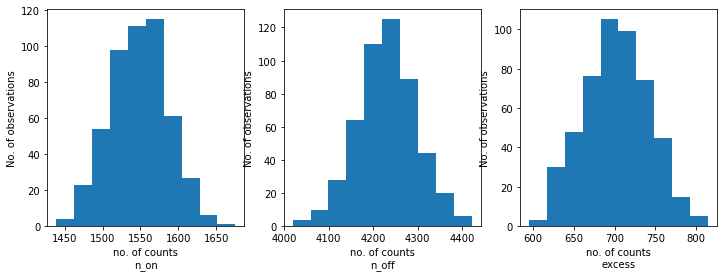

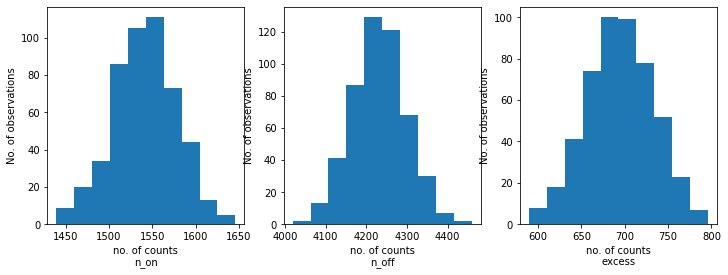

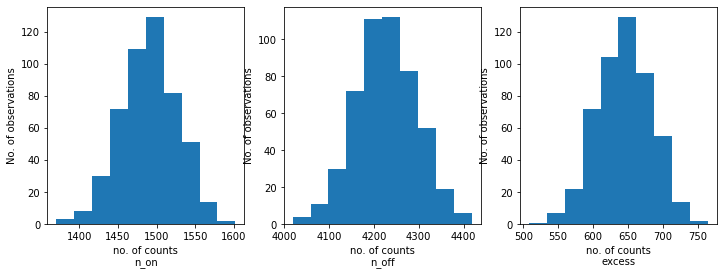

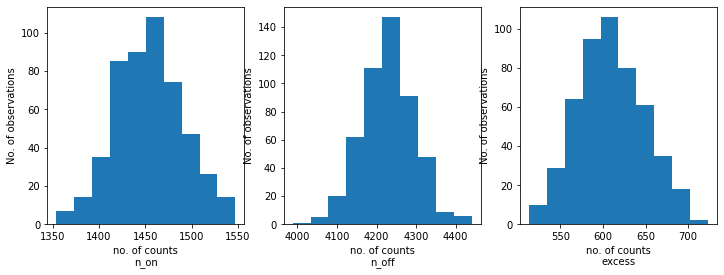

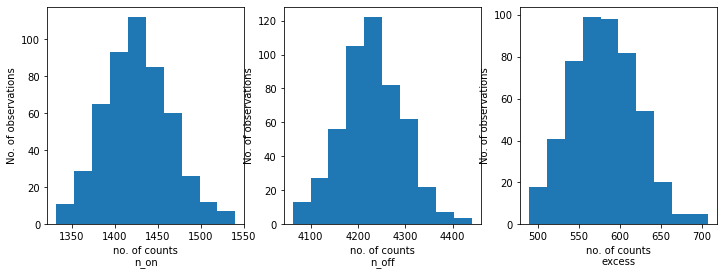

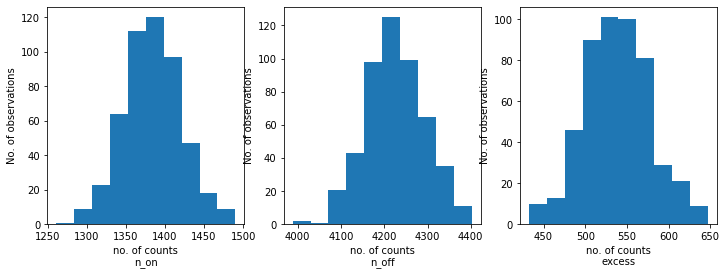

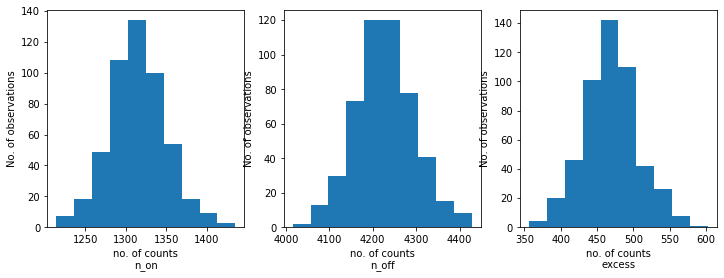

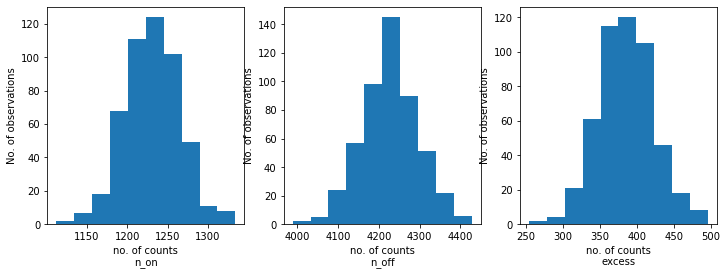

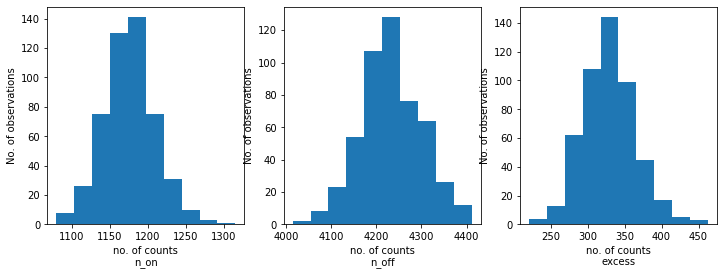

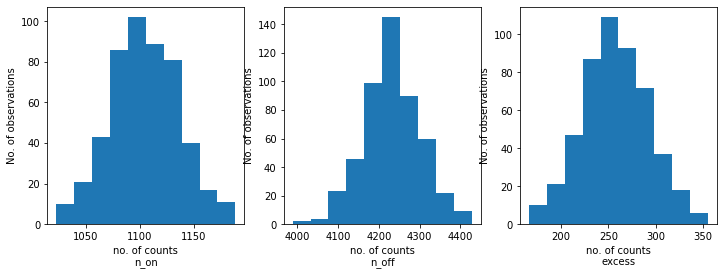

In [14]:
for i in range(10):
    n_on = [dataset.counts.data.sum() for dataset in datas[i]]
    n_off = [dataset.counts_off.data.sum() for dataset in datas[i]]
    excess = [dataset.excess.data.sum() for dataset in datas[i]]
    
    fix, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].hist(n_on)
    axes[0].set_xlabel("no. of counts\nn_on")
    axes[0].set_ylabel("No. of observations")
    axes[1].hist(n_off)
    axes[1].set_xlabel("no. of counts\nn_off")
    axes[1].set_ylabel("No. of observations")
    axes[2].hist(excess)
    axes[2].set_xlabel("no. of counts\nexcess");
    axes[2].set_ylabel("No. of observations")

In [15]:
%%time
res = []
results = []
for dataset in datas[0]:
    dataset.models = model[0].copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "reference":result.parameters["reference"].value,
        }
    )
    print(result.parameters.to_table())
res.append(results)

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.208e+00   nan                nan nan  False
amplitude 1.446e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.210e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.198e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.240e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.362e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.255e+00   nan                nan nan  False
amplitude 1.167e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.252e+00   nan                nan nan  False
amplitude 1.321e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.287e+00   nan                nan nan  False
amplitude 1.215e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.261e+00   nan                nan nan  False
amplitude 1.334e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.262e+00   nan                nan nan  False
amplitude 1.261e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.174e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.163e+00   nan                nan nan  False
amplitude 1.298e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.244e+00   nan                nan nan  False
amplitude 1.266e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.296e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.193e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.262e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan  False
amplitude 1.379e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan  False
amplitude 1.168e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.182e+00   nan                nan nan  False
amplitude 1.377e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.184e+00   nan                nan nan  False
amplitude 1.173e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.238e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.184e+00   nan                nan nan  False
amplitude 1.299e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.314e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.173e+00   nan                nan nan  False
amplitude 1.205e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.197e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.266e+00   nan                nan nan  False
amplitude 1.306e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan  False
amplitude 1.255e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.280e+00   nan                nan nan  False
amplitude 1.324e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.189e+00   nan                nan nan  False
amplitude 1.285e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.285e+00   nan                nan nan  False
amplitude 1.239e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.195e+00   nan                nan nan  False
amplitude 1.241e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.181e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.174e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan  False
amplitude 1.281e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.178e+00   nan                nan nan  False
amplitude 1.243e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.212e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.248e+00   nan                nan nan  False
amplitude 1.173e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.217e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.362e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.241e+00   nan                nan nan  False
amplitude 1.128e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.259e+00   nan                nan nan  False
amplitude 1.130e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.169e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.246e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.150e+00   nan                nan nan  False
amplitude 1.285e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.208e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.196e+00   nan                nan nan  False
amplitude 1.266e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.223e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.394e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.335e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.306e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.261e+00   nan                nan nan  False
amplitude 1.188e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.188e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.246e+00   nan                nan nan  False
amplitude 1.342e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.286e+00   nan                nan nan  False
amplitude 1.327e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.197e+00   nan                nan nan  False
amplitude 1.269e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.205e+00   nan                nan nan  False
amplitude 1.243e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.345e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.186e+00   nan                nan nan  False
amplitude 1.377e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.242e+00   nan                nan nan

In [16]:
for i in range(9):
    results = []
    for dataset in datas[i+1]:
        dataset.models = model[i+1].copy()
        fit = Fit([dataset])
        result = fit.optimize()
        results.append(
            {
                "index": result.parameters["index"].value,
                "amplitude": result.parameters["amplitude"].value,
                "lambda_": result.parameters["lambda_"].value,
                "reference":result.parameters["reference"].value,
                "alpha":result.parameters["alpha"].value,
            }
        )
        print(result.parameters.to_table())
    res.append(results)

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.481e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.649e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.203e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.021e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.191e+00   nan                nan nan  False
amplitude 1.213e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  2.243e+00   nan                nan nan  False
amplitude  1.154e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference  1.000e+00   nan            TeV nan nan   True
  lambda_ -6.908e-03   nan          TeV-1 nan nan  False
    alpha  1.000e+00   nan                nan nan   True
   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  2.259e+00   nan                nan nan  False
amplitude  1.218e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference  1.000e+00   nan            TeV nan nan   True
  lambda_ -4.235e-04   nan          TeV-1 nan nan  False
    alpha  1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.339e-12   nan cm-2 s-1

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.274e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.116e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.257e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.617e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.166e+00   nan                nan nan  False
amplitude 1.335e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  2.291e+00   nan                nan nan  False
amplitude  1.092e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference  1.000e+00   nan            TeV nan nan   True
  lambda_ -1.592e-02   nan          TeV-1 nan nan  False
    alpha  1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.179e+00   nan                nan nan  False
amplitude 1.379e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.642e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.235e+00   nan                nan nan  False
amplitude 1.206e-12   nan cm-2 s-1 TeV-1 

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.160e+00   nan                nan nan  False
amplitude 1.252e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.887e-04   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.183e+00   nan                nan nan  False
amplitude 1.390e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.723e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.152e+00   nan                nan nan  False
amplitude 1.304e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.198e+00   nan                nan nan  False
amplitude 1.367e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.340e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  2.280e+00   nan                nan nan  False
amplitude  1.131e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference  1.000e+00   nan            TeV nan nan   True
  lambda_ -1.015e-02   nan          TeV-1 nan nan  False
    alpha  1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.168e+00   nan                nan nan  False
amplitude 1.313e-12   nan cm-2 s-1 TeV-1 

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.325e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.899e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.171e+00   nan                nan nan  False
amplitude 1.335e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.859e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  2.279e+00   nan                nan nan  False
amplitude  1.153e-12   nan cm-2 s-1 TeV-1 nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.268e+00   nan                nan nan  False
amplitude 1.219e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.834e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.163e+00   nan                nan nan  False
amplitude 1.463e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.494e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  2.274e+00   nan                nan nan  False
amplitude  1.231e-12   nan cm-2 s-1 TeV-1 nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.314e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.358e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.265e+00   nan                nan nan  False
amplitude 1.219e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.212e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.143e+00   nan                nan nan  False
amplitude 1.462e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  2.290e+00   nan                nan nan  False
amplitude  1.200e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference  1.000e+00   nan            TeV nan nan   True
  lambda_ -2.715e-03   nan          TeV-1 nan nan  False
    alpha  1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.202e+00   nan                nan nan  False
amplitude 1.340e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.015e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.143e+00   nan                nan nan  False
amplitude 1.371e-12   nan cm-2 s-1 TeV-1 

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.346e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.681e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  2.283e+00   nan                nan nan  False
amplitude  1.269e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference  1.000e+00   nan            TeV nan nan   True
  lambda_ -6.974e-03   nan          TeV-1 nan nan  False
    alpha  1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.301e-12   nan cm-2 s-1 TeV-1 

   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  2.241e+00   nan                nan nan  False
amplitude  1.112e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference  1.000e+00   nan            TeV nan nan   True
  lambda_ -1.107e-02   nan          TeV-1 nan nan  False
    alpha  1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.178e+00   nan                nan nan  False
amplitude 1.184e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.719e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.138e+00   nan                nan nan  False
amplitude 1.279e-12   nan cm-2 s-1 TeV-1 

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.211e+00   nan                nan nan  False
amplitude 1.402e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.935e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.177e+00   nan                nan nan  False
amplitude 1.239e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.028e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.248e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  2.220e+00   nan                nan nan  False
amplitude  1.248e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference  1.000e+00   nan            TeV nan nan   True
  lambda_ -2.440e-03   nan          TeV-1 nan nan  False
    alpha  1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.155e+00   nan                nan nan  False
amplitude 1.385e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.278e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.190e-12   nan cm-2 s-1 TeV-1 

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.237e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.171e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.197e+00   nan                nan nan  False
amplitude 1.408e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.288e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.352e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  2.234e+00   nan                nan nan  False
amplitude  1.178e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference  1.000e+00   nan            TeV nan nan   True
  lambda_ -3.093e-03   nan          TeV-1 nan nan  False
    alpha  1.000e+00   nan                nan nan   True
   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  2.254e+00   nan                nan nan  False
amplitude  1.263e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference  1.000e+00   nan            TeV nan nan   True
  lambda_ -2.556e-03   nan          TeV-1 nan nan  False
    alpha  1.000e+00   nan                nan nan   True
   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  2.227e+00   nan                nan nan  False
amplitude  1.234e-12   nan cm-2

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.188e+00   nan                nan nan  False
amplitude 1.390e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.093e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.250e+00   nan                nan nan  False
amplitude 1.272e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.312e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.199e+00   nan                nan nan  False
amplitude 1.317e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.366e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.971e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.188e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.251e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.240e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.177e+00   nan                nan nan  False
amplitude 1.361e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.025e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.224e+00   nan                nan nan  False
amplitude 1.352e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.303e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  2.245e+00   nan                nan nan  False
amplitude  1.190e-12   nan cm-2 s-1 TeV-1 nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.142e+00   nan                nan nan  False
amplitude 1.284e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.476e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.181e+00   nan                nan nan  False
amplitude 1.368e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.291e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.222e+00   nan                nan nan  False
amplitude 1.237e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.257e+00   nan                nan nan  False
amplitude 1.181e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.470e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  2.216e+00   nan                nan nan  False
amplitude  1.255e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference  1.000e+00   nan            TeV nan nan   True
  lambda_ -2.513e-04   nan          TeV-1 nan nan  False
    alpha  1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.179e+00   nan                nan nan  False
amplitude 1.560e-12   nan cm-2 s-1 TeV-1 

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.168e+00   nan                nan nan  False
amplitude 1.427e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.980e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.310e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  2.239e+00   nan                nan nan  False
amplitude  1.150e-12   nan cm-2 s-1 TeV-1 nan

   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  2.268e+00   nan                nan nan  False
amplitude  1.226e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference  1.000e+00   nan            TeV nan nan   True
  lambda_ -4.554e-03   nan          TeV-1 nan nan  False
    alpha  1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.266e+00   nan                nan nan  False
amplitude 1.146e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.380e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  2.274e+00   nan                nan nan  False
amplitude  1.136e-12   nan cm-2 s-1 Te

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.354e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.726e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.168e+00   nan                nan nan  False
amplitude 1.407e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.228e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.262e+00   nan                nan nan  False
amplitude 1.247e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.269e+00   nan                nan nan  False
amplitude 1.202e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.293e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.256e+00   nan                nan nan  False
amplitude 1.196e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.833e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.265e+00   nan                nan nan  False
amplitude 1.212e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.275e+00   nan                nan nan  False
amplitude 1.204e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.761e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.108e+00   nan                nan nan  False
amplitude 1.602e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.071e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.332e+00   nan                nan nan  False
amplitude 1.034e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.302e+00   nan                nan nan  False
amplitude 1.178e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.048e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.265e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.217e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.245e+00   nan                nan nan  False
amplitude 1.329e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.182e+00   nan                nan nan  False
amplitude 1.502e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.605e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.159e+00   nan                nan nan  False
amplitude 1.387e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.435e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.140e+00   nan                nan nan  False
amplitude 1.501e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.242e+00   nan                nan nan  False
amplitude 1.166e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.924e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.180e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.025e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.109e+00   nan                nan nan  False
amplitude 1.553e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.968e+00   nan                nan nan  False
amplitude 2.014e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.603e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.284e+00   nan                nan nan  False
amplitude 1.115e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.042e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.231e+00   nan                nan nan  False
amplitude 1.447e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.198e+00   nan                nan nan  False
amplitude 1.227e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.505e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.202e+00   nan                nan nan  False
amplitude 1.511e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.687e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.194e+00   nan                nan nan  False
amplitude 1.268e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.256e+00   nan                nan nan  False
amplitude 1.141e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.489e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.253e+00   nan                nan nan  False
amplitude 1.217e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.757e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.193e+00   nan                nan nan  False
amplitude 1.360e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.241e+00   nan                nan nan  False
amplitude 1.184e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.669e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.099e+00   nan                nan nan  False
amplitude 1.515e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.440e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.166e+00   nan                nan nan  False
amplitude 1.487e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.315e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.390e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.315e+00   nan                nan nan  False
amplitude 1.112e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.206e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.169e+00   nan                nan nan  False
amplitude 1.362e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.140e+00   nan                nan nan  False
amplitude 1.497e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.398e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.250e+00   nan                nan nan  False
amplitude 1.088e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.462e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.178e+00   nan                nan nan  False
amplitude 1.441e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.079e+00   nan                nan nan  False
amplitude 1.640e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.974e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.307e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.763e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.103e+00   nan                nan nan  False
amplitude 1.405e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.279e+00   nan                nan nan  False
amplitude 1.231e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.401e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.158e+00   nan                nan nan  False
amplitude 1.487e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.632e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.149e+00   nan                nan nan  False
amplitude 1.509e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.276e+00   nan                nan nan  False
amplitude 1.262e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.692e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.283e+00   nan                nan nan  False
amplitude 1.322e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.238e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.171e+00   nan                nan nan  False
amplitude 1.341e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.327e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.023e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.165e+00   nan                nan nan  False
amplitude 1.392e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.204e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.334e+00   nan                nan nan  False
amplitude 1.078e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.296e+00   nan                nan nan  False
amplitude 1.231e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.086e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.317e+00   nan                nan nan  False
amplitude 1.212e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.548e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.198e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.270e+00   nan                nan nan  False
amplitude 1.098e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.774e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.356e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.270e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.189e+00   nan                nan nan  False
amplitude 1.334e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.101e+00   nan                nan nan  False
amplitude 1.619e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.386e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.022e+00   nan                nan nan  False
amplitude 1.668e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.384e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.152e+00   nan                nan nan  False
amplitude 1.252e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.269e+00   nan                nan nan  False
amplitude 1.243e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.857e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.289e+00   nan                nan nan  False
amplitude 1.227e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.630e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.164e+00   nan                nan nan  False
amplitude 1.329e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.308e+00   nan                nan nan  False
amplitude 1.201e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.138e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.132e+00   nan                nan nan  False
amplitude 1.498e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.033e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.146e+00   nan                nan nan  False
amplitude 1.453e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.267e+00   nan                nan nan  False
amplitude 1.194e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.239e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.300e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.248e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.337e+00   nan                nan nan  False
amplitude 9.804e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.170e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.611e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.294e+00   nan                nan nan  False
amplitude 1.212e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.485e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.317e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.182e+00   nan                nan nan  False
amplitude 1.339e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.383e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.267e+00   nan                nan nan  False
amplitude 1.188e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.559e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.321e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.270e+00   nan                nan nan  False
amplitude 1.239e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.067e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.328e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.553e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.147e+00   nan                nan nan  False
amplitude 1.456e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.169e+00   nan                nan nan  False
amplitude 1.331e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.534e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.335e+00   nan                nan nan  False
amplitude 1.003e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.297e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.036e+00   nan                nan nan  False
amplitude 1.853e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.151e+00   nan                nan nan  False
amplitude 1.685e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.596e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.198e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.915e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.371e+00   nan                nan nan  False
amplitude 1.051e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.158e+00   nan                nan nan  False
amplitude 1.360e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.776e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.253e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.535e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.099e+00   nan                nan nan  False
amplitude 1.685e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.335e+00   nan                nan nan  False
amplitude 1.067e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.438e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.104e+00   nan                nan nan  False
amplitude 1.449e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.779e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.122e+00   nan                nan nan  False
amplitude 1.573e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.423e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.518e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.237e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.407e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.331e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.235e+00   nan                nan nan  False
amplitude 1.437e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.562e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.008e+00   nan                nan nan  False
amplitude 1.983e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.636e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.307e+00   nan                nan nan  False
amplitude 9.582e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.123e+00   nan                nan nan  False
amplitude 1.568e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.419e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.244e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.022e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.121e+00   nan                nan nan  False
amplitude 1.722e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.149e+00   nan                nan nan  False
amplitude 1.406e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.091e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.416e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.423e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.127e+00   nan                nan nan  False
amplitude 1.756e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.163e+00   nan                nan nan  False
amplitude 1.418e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.131e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.314e+00   nan                nan nan  False
amplitude 1.009e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.225e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.405e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.044e+00   nan                nan nan  False
amplitude 1.566e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.008e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.151e+00   nan                nan nan  False
amplitude 1.513e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.471e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.283e+00   nan                nan nan  False
amplitude 1.248e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.131e+00   nan                nan nan  False
amplitude 1.658e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.774e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.243e+00   nan                nan nan  False
amplitude 1.149e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.365e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.019e+00   nan                nan nan  False
amplitude 1.939e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.126e+00   nan                nan nan  False
amplitude 1.446e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.766e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.276e+00   nan                nan nan  False
amplitude 1.310e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.521e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.287e+00   nan                nan nan  False
amplitude 1.247e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.433e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.865e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.347e+00   nan                nan nan  False
amplitude 9.834e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.787e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.196e+00   nan                nan nan  False
amplitude 1.584e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.204e+00   nan                nan nan  False
amplitude 1.271e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.935e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.213e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.671e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.274e+00   nan                nan nan  False
amplitude 1.078e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.304e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.294e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.451e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.533e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.072e+00   nan                nan nan  False
amplitude 1.692e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.217e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.383e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.316e+00   nan                nan nan  False
amplitude 1.186e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.138e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.169e+00   nan                nan nan  False
amplitude 1.468e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.183e+00   nan                nan nan  False
amplitude 1.313e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.314e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.240e+00   nan                nan nan  False
amplitude 1.231e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.606e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.210e+00   nan                nan nan  False
amplitude 1.469e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.239e+00   nan                nan nan  False
amplitude 1.254e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.336e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.098e+00   nan                nan nan  False
amplitude 1.440e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.202e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.370e+00   nan                nan nan  False
amplitude 9.689e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.170e+00   nan                nan nan  False
amplitude 1.421e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.663e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.258e+00   nan                nan nan  False
amplitude 1.118e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.719e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.159e+00   nan                nan nan  False
amplitude 1.402e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.197e+00   nan                nan nan  False
amplitude 1.423e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.835e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.091e+00   nan                nan nan  False
amplitude 1.902e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.354e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.167e+00   nan                nan nan  False
amplitude 1.524e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.328e+00   nan                nan nan  False
amplitude 1.080e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.161e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.339e+00   nan                nan nan  False
amplitude 1.077e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.277e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.162e+00   nan                nan nan  False
amplitude 1.435e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.209e+00   nan                nan nan  False
amplitude 1.302e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.755e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.256e+00   nan                nan nan  False
amplitude 1.195e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.754e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.303e+00   nan                nan nan  False
amplitude 1.052e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.076e+00   nan                nan nan  False
amplitude 1.723e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.460e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.294e+00   nan                nan nan  False
amplitude 1.148e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.312e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.098e+00   nan                nan nan  False
amplitude 1.858e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.279e+00   nan                nan nan  False
amplitude 1.210e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.992e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.124e+00   nan                nan nan  False
amplitude 1.700e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.331e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.291e+00   nan                nan nan  False
amplitude 1.237e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.346e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.017e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.337e+00   nan                nan nan  False
amplitude 1.137e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.885e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.282e+00   nan                nan nan  False
amplitude 9.860e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.314e+00   nan                nan nan  False
amplitude 1.161e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.597e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.234e+00   nan                nan nan  False
amplitude 1.241e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.085e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.275e+00   nan                nan nan  False
amplitude 1.239e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.272e+00   nan                nan nan  False
amplitude 1.175e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.707e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.263e+00   nan                nan nan  False
amplitude 1.167e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.009e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.323e+00   nan                nan nan  False
amplitude 9.726e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.226e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.167e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.413e+00   nan                nan nan  False
amplitude 8.926e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.501e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.194e+00   nan                nan nan  False
amplitude 1.299e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.119e+00   nan                nan nan  False
amplitude 1.593e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.600e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.301e+00   nan                nan nan  False
amplitude 1.194e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.879e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.158e+00   nan                nan nan  False
amplitude 1.453e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.241e+00   nan                nan nan  False
amplitude 1.126e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.022e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.352e+00   nan                nan nan  False
amplitude 1.022e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.144e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.171e+00   nan                nan nan  False
amplitude 1.322e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.343e+00   nan                nan nan  False
amplitude 1.018e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.313e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.258e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.587e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.240e+00   nan                nan nan  False
amplitude 1.124e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.247e+00   nan                nan nan  False
amplitude 1.226e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.231e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.152e+00   nan                nan nan  False
amplitude 1.242e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.672e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.121e+00   nan                nan nan  False
amplitude 1.681e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.362e+00   nan                nan nan  False
amplitude 9.960e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.739e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.149e+00   nan                nan nan  False
amplitude 1.543e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.917e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.398e+00   nan                nan nan  False
amplitude 8.795e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.150e+00   nan                nan nan  False
amplitude 1.571e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.006e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.242e+00   nan                nan nan  False
amplitude 1.402e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.402e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.346e+00   nan                nan nan  False
amplitude 1.069e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.329e+00   nan                nan nan  False
amplitude 9.894e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.109e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.242e+00   nan                nan nan  False
amplitude 1.318e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.783e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.297e+00   nan                nan nan  False
amplitude 1.047e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.125e+00   nan                nan nan  False
amplitude 1.456e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.638e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.161e+00   nan                nan nan  False
amplitude 1.748e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.387e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.440e+00   nan                nan nan  False
amplitude 8.688e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.116e+00   nan                nan nan  False
amplitude 1.498e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.157e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.294e+00   nan                nan nan  False
amplitude 1.070e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.358e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.301e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.202e+00   nan                nan nan  False
amplitude 1.366e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.896e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.948e+00   nan                nan nan  False
amplitude 2.134e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.973e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.256e+00   nan                nan nan  False
amplitude 1.332e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.111e+00   nan                nan nan  False
amplitude 1.575e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.334e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.265e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.672e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.386e+00   nan                nan nan  False
amplitude 9.892e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.136e+00   nan                nan nan  False
amplitude 1.607e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.585e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.156e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.299e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.261e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.082e+00   nan                nan nan  False
amplitude 1.808e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.827e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.197e+00   nan                nan nan  False
amplitude 1.368e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.370e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.114e+00   nan                nan nan  False
amplitude 1.667e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.167e+00   nan                nan nan  False
amplitude 1.527e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.901e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.117e+00   nan                nan nan  False
amplitude 1.494e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.199e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.264e+00   nan                nan nan  False
amplitude 1.181e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.272e+00   nan                nan nan  False
amplitude 1.103e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.941e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.237e+00   nan                nan nan  False
amplitude 1.273e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.208e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.393e+00   nan                nan nan  False
amplitude 1.037e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.144e+00   nan                nan nan  False
amplitude 1.548e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.253e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.176e+00   nan                nan nan  False
amplitude 1.201e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.509e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.347e+00   nan                nan nan  False
amplitude 1.128e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.158e+00   nan                nan nan  False
amplitude 1.595e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.896e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.002e+00   nan                nan nan  False
amplitude 1.884e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.399e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.182e+00   nan                nan nan  False
amplitude 1.589e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.381e+00   nan                nan nan  False
amplitude 1.173e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.916e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.188e+00   nan                nan nan  False
amplitude 1.125e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.134e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.300e+00   nan                nan nan  False
amplitude 1.145e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.267e+00   nan                nan nan  False
amplitude 1.051e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.686e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.098e+00   nan                nan nan  False
amplitude 1.478e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.986e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.146e+00   nan                nan nan  False
amplitude 1.633e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.118e+00   nan                nan nan  False
amplitude 1.603e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.263e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.467e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.871e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.069e+00   nan                nan nan  False
amplitude 1.731e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.115e+00   nan                nan nan  False
amplitude 1.404e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.922e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.078e+00   nan                nan nan  False
amplitude 2.006e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.013e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.089e+00   nan                nan nan  False
amplitude 1.768e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.364e+00   nan                nan nan  False
amplitude 1.021e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.254e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.330e+00   nan                nan nan  False
amplitude 1.102e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.877e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.192e+00   nan                nan nan  False
amplitude 1.477e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.259e+00   nan                nan nan  False
amplitude 1.276e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.055e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.109e+00   nan                nan nan  False
amplitude 1.680e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.359e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.917e+00   nan                nan nan  False
amplitude 2.673e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.094e+00   nan                nan nan  False
amplitude 1.908e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.314e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.410e+00   nan                nan nan  False
amplitude 1.011e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.721e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.288e+00   nan                nan nan  False
amplitude 1.121e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.183e+00   nan                nan nan  False
amplitude 1.406e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.216e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.285e+00   nan                nan nan  False
amplitude 1.098e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.873e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.176e+00   nan                nan nan  False
amplitude 1.522e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.112e+00   nan                nan nan  False
amplitude 1.746e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.213e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.134e+00   nan                nan nan  False
amplitude 1.660e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.547e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.198e+00   nan                nan nan  False
amplitude 1.321e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.357e+00   nan                nan nan  False
amplitude 8.384e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.823e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.991e+00   nan                nan nan  False
amplitude 2.120e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.595e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.255e+00   nan                nan nan  False
amplitude 1.293e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.131e+00   nan                nan nan  False
amplitude 1.648e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.577e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.298e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.397e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.240e+00   nan                nan nan  False
amplitude 1.219e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.237e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.256e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.338e+00   nan                nan nan  False
amplitude 1.040e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.056e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.033e+00   nan                nan nan  False
amplitude 1.802e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.253e+00   nan                nan nan  False
amplitude 1.193e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.939e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.156e+00   nan                nan nan  False
amplitude 1.420e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.091e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.064e+00   nan                nan nan  False
amplitude 1.641e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.249e+00   nan                nan nan  False
amplitude 1.032e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.601e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.326e+00   nan                nan nan  False
amplitude 9.952e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.989e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.437e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.315e+00   nan                nan nan  False
amplitude 9.040e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.767e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.253e+00   nan                nan nan  False
amplitude 1.308e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.165e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.183e+00   nan                nan nan  False
amplitude 1.451e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.203e+00   nan                nan nan  False
amplitude 1.260e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.302e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.251e+00   nan                nan nan  False
amplitude 1.161e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.420e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.278e+00   nan                nan nan  False
amplitude 1.081e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.286e+00   nan                nan nan  False
amplitude 1.003e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.545e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.255e+00   nan                nan nan  False
amplitude 1.232e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.380e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.257e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 1.141e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.277e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.052e+00   nan                nan nan  False
amplitude 2.331e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.140e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.094e+00   nan                nan nan  False
amplitude 1.832e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.137e+00   nan                nan nan  False
amplitude 1.674e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.840e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.149e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.544e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.108e+00   nan                nan nan  False
amplitude 1.539e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.159e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.057e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.955e+00   nan                nan nan  False
amplitude 2.303e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.502e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.155e+00   nan                nan nan  False
amplitude 1.599e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.994e+00   nan                nan nan  False
amplitude 1.886e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.416e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.076e+00   nan                nan nan  False
amplitude 1.606e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.373e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.384e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.253e+00   nan                nan nan  False
amplitude 1.188e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.464e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.436e+00   nan                nan nan  False
amplitude 8.654e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.888e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.236e+00   nan                nan nan  False
amplitude 1.437e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.879e+00   nan                nan nan  False
amplitude 2.954e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.287e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.078e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.040e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.138e+00   nan                nan nan  False
amplitude 1.630e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.276e+00   nan                nan nan  False
amplitude 1.036e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.461e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.399e+00   nan                nan nan  False
amplitude 8.395e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.089e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.274e+00   nan                nan nan  False
amplitude 1.231e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.096e+00   nan                nan nan  False
amplitude 1.698e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.902e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.176e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.737e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.317e+00   nan                nan nan  False
amplitude 1.042e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.182e+00   nan                nan nan  False
amplitude 1.484e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.832e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.487e+00   nan                nan nan  False
amplitude 7.731e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.835e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.295e+00   nan                nan nan  False
amplitude 1.090e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.421e+00   nan                nan nan  False
amplitude 7.566e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.444e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.062e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.907e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.381e+00   nan                nan nan  False
amplitude 9.476e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.102e+00   nan                nan nan  False
amplitude 1.661e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.513e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.118e+00   nan                nan nan  False
amplitude 1.649e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.280e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.190e+00   nan                nan nan  False
amplitude 1.472e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.198e+00   nan                nan nan  False
amplitude 1.377e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.150e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.925e+00   nan                nan nan  False
amplitude 2.120e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.698e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.421e+00   nan                nan nan  False
amplitude 9.538e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.350e+00   nan                nan nan  False
amplitude 9.309e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.985e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.163e+00   nan                nan nan  False
amplitude 1.457e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.170e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.173e+00   nan                nan nan  False
amplitude 1.478e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.859e+00   nan                nan nan  False
amplitude 2.672e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.896e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.194e+00   nan                nan nan  False
amplitude 1.278e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.518e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.250e+00   nan                nan nan  False
amplitude 1.105e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.280e+00   nan                nan nan  False
amplitude 1.091e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.018e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.123e+00   nan                nan nan  False
amplitude 1.997e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.313e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.507e+00   nan                nan nan  False
amplitude 6.742e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.983e+00   nan                nan nan  False
amplitude 2.039e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.273e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.978e+00   nan                nan nan  False
amplitude 2.243e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.433e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.055e+00   nan                nan nan  False
amplitude 1.694e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.854e+00   nan                nan nan  False
amplitude 3.564e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.622e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.164e+00   nan                nan nan  False
amplitude 1.283e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.623e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.260e+00   nan                nan nan  False
amplitude 1.324e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.077e+00   nan                nan nan  False
amplitude 1.790e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.380e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.383e+00   nan                nan nan  False
amplitude 9.758e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.134e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.133e+00   nan                nan nan  False
amplitude 1.428e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.448e+00   nan                nan nan  False
amplitude 8.718e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.573e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.202e+00   nan                nan nan  False
amplitude 1.423e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.072e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.066e+00   nan                nan nan  False
amplitude 1.590e-12   nan cm-2 s-1 TeV-1 nan nan

/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/gammapy/stats/fit_statistics.py:196: RuntimeWarning: overflow encountered in square
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.615e+00   nan                nan nan  False
amplitude 4.675e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.099e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.856e+00   nan                nan nan  False
amplitude 2.577e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.603e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.289e+00   nan                nan nan  False
amplitude 1.079e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.257e+00   nan                nan nan  False
amplitude 1.110e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.499e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.161e+00   nan                nan nan  False
amplitude 1.539e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.360e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.160e+00   nan                nan nan  False
amplitude 1.309e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.082e+00   nan                nan nan  False
amplitude 1.837e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.232e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.123e+00   nan                nan nan  False
amplitude 2.004e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.067e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.847e+00   nan                nan nan  False
amplitude 2.690e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.095e+00   nan                nan nan  False
amplitude 1.867e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.439e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.877e+00   nan                nan nan  False
amplitude 2.477e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.531e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.362e+00   nan                nan nan  False
amplitude 1.145e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.304e+00   nan                nan nan  False
amplitude 1.135e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.342e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.032e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.503e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.117e+00   nan                nan nan  False
amplitude 1.700e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.016e+00   nan                nan nan  False
amplitude 1.873e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.159e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.383e+00   nan                nan nan  False
amplitude 9.234e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.540e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.065e+00   nan                nan nan  False
amplitude 1.884e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.998e+00   nan                nan nan  False
amplitude 2.188e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.510e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.082e+00   nan                nan nan  False
amplitude 1.714e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.253e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.135e+00   nan                nan nan  False
amplitude 1.786e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.051e+00   nan                nan nan  False
amplitude 1.858e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.565e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.997e+00   nan                nan nan  False
amplitude 2.228e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.599e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.340e+00   nan                nan nan  False
amplitude 1.029e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.214e+00   nan                nan nan  False
amplitude 1.319e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.213e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.380e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.028e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.182e+00   nan                nan nan  False
amplitude 1.300e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.091e+00   nan                nan nan  False
amplitude 1.583e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.025e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.180e+00   nan                nan nan  False
amplitude 1.407e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.147e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.259e+00   nan                nan nan  False
amplitude 1.139e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.245e+00   nan                nan nan  False
amplitude 1.262e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.118e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.274e+00   nan                nan nan  False
amplitude 9.714e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.585e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.287e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.030e+00   nan                nan nan  False
amplitude 2.456e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.052e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.879e+00   nan                nan nan  False
amplitude 3.096e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.182e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.168e+00   nan                nan nan  False
amplitude 1.587e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.318e+00   nan                nan nan  False
amplitude 9.243e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.915e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.057e+00   nan                nan nan  False
amplitude 2.014e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.458e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.407e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.557e+00   nan                nan nan  False
amplitude 5.686e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.553e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.041e+00   nan                nan nan  False
amplitude 2.211e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.352e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.308e+00   nan                nan nan  False
amplitude 9.392e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.212e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.770e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.003e+00   nan                nan nan  False
amplitude 2.450e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.614e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.115e+00   nan                nan nan  False
amplitude 1.824e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.511e+00   nan                nan nan  False
amplitude 5.979e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.155e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.330e+00   nan                nan nan  False
amplitude 7.256e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.028e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.431e+00   nan                nan nan  False
amplitude 6.161e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.151e+00   nan                nan nan  False
amplitude 1.697e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.054e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.289e+00   nan                nan nan  False
amplitude 1.072e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.378e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.874e+00   nan                nan nan  False
amplitude 3.506e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.497e+00   nan                nan nan  False
amplitude 6.397e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.996e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.060e+00   nan                nan nan  False
amplitude 2.023e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.654e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.432e+00   nan                nan nan  False
amplitude 7.085e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.382e+00   nan                nan nan  False
amplitude 8.077e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.026e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.974e+00   nan                nan nan  False
amplitude 2.509e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.483e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.937e+00   nan                nan nan  False
amplitude 2.450e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.830e+00   nan                nan nan  False
amplitude 3.041e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.154e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.410e+00   nan                nan nan  False
amplitude 8.681e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.519e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.764e+00   nan                nan nan  False
amplitude 3.579e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.240e+00   nan                nan nan  False
amplitude 1.365e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.182e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.550e+00   nan                nan nan  False
amplitude 5.610e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.921e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.075e+00   nan                nan nan  False
amplitude 2.087e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.475e+00   nan                nan nan  False
amplitude 5.894e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.879e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.845e+00   nan                nan nan  False
amplitude 3.306e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.850e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.967e+00   nan                nan nan  False
amplitude 2.339e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.361e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.221e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.361e+00   nan                nan nan  False
amplitude 1.022e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.455e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.127e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.215e+00   nan                nan nan  False
amplitude 1.465e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.353e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.319e+00   nan                nan nan  False
amplitude 1.297e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.338e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.196e+00   nan                nan nan  False
amplitude 1.184e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.924e+00   nan                nan nan  False
amplitude 2.288e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.390e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.885e+00   nan                nan nan  False
amplitude 4.166e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.795e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.857e+00   nan                nan nan  False
amplitude 2.295e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.698e+00   nan                nan nan  False
amplitude 2.967e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.221e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.082e+00   nan                nan nan  False
amplitude 2.144e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.623e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.157e+00   nan                nan nan  False
amplitude 1.591e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.511e+00   nan                nan nan  False
amplitude 5.147e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.911e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.228e+00   nan                nan nan  False
amplitude 1.171e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.474e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.418e+00   nan                nan nan  False
amplitude 7.666e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.152e+00   nan                nan nan  False
amplitude 1.582e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.097e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.189e+00   nan                nan nan  False
amplitude 1.346e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.329e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.330e+00   nan                nan nan  False
amplitude 1.097e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.985e+00   nan                nan nan  False
amplitude 1.903e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.270e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.123e+00   nan                nan nan  False
amplitude 1.444e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.362e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.356e+00   nan                nan nan  False
amplitude 8.618e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.881e+00   nan                nan nan  False
amplitude 3.407e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.036e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.213e+00   nan                nan nan  False
amplitude 1.265e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.052e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.235e+00   nan                nan nan  False
amplitude 1.220e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.520e+00   nan                nan nan  False
amplitude 6.214e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.157e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.560e+00   nan                nan nan  False
amplitude 6.514e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.199e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 8.871e-01   nan                nan nan  False
amplitude 3.456e-11   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.007e+00   nan                nan nan  False
amplitude 2.028e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.138e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.206e+00   nan                nan nan  False
amplitude 1.336e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.164e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.182e+00   nan                nan nan  False
amplitude 1.300e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.425e+00   nan                nan nan  False
amplitude 7.128e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.117e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.964e+00   nan                nan nan  False
amplitude 3.013e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.175e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.625e+00   nan                nan nan  False
amplitude 6.349e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.326e+00   nan                nan nan  False
amplitude 9.150e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.378e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.012e+00   nan                nan nan  False
amplitude 3.258e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.508e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.192e+00   nan                nan nan  False
amplitude 1.366e-12   nan cm-2 s-1 TeV-1 nan nan

/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/astropy/units/quantity.py:481: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  6.688e+00   nan                nan nan  False
amplitude -3.698e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference  1.000e+00   nan            TeV nan nan   True
  lambda_ -7.768e+00   nan          TeV-1 nan nan  False
    alpha  1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.357e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.558e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.994e+00   nan                nan nan  False
amplitude 2.786e-12   nan cm-2 s-1 TeV-1 

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.320e+00   nan                nan nan  False
amplitude 1.319e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.543e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.068e+00   nan                nan nan  False
amplitude 2.092e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.280e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.511e+00   nan                nan nan  False
amplitude 5.748e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.899e+00   nan                nan nan  False
amplitude 3.606e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.783e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.811e+00   nan                nan nan  False
amplitude 3.658e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.678e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.886e+00   nan                nan nan  False
amplitude 3.869e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.303e+00   nan                nan nan  False
amplitude 1.059e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.112e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.330e+00   nan                nan nan  False
amplitude 8.367e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.105e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.183e+00   nan                nan nan  False
amplitude 1.625e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.144e+00   nan                nan nan  False
amplitude 1.613e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.069e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.472e+00   nan                nan nan  False
amplitude 8.825e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.910e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.762e+00   nan                nan nan  False
amplitude 4.270e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.259e+00   nan                nan nan  False
amplitude 2.069e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.288e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.037e+00   nan                nan nan  False
amplitude 1.600e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.512e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.393e+00   nan                nan nan  False
amplitude 7.735e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.420e+00   nan                nan nan  False
amplitude 6.757e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.938e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.381e+00   nan                nan nan  False
amplitude 9.221e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.258e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.659e+00   nan                nan nan  False
amplitude 3.116e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.412e+00   nan                nan nan  False
amplitude 7.460e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.316e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.553e+00   nan                nan nan  False
amplitude 5.714e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.215e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.363e+00   nan                nan nan  False
amplitude 7.445e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.560e+00   nan                nan nan  False
amplitude 1.033e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.267e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.431e+00   nan                nan nan  False
amplitude 8.949e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.146e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.632e+00   nan                nan nan  False
amplitude 3.433e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.891e+00   nan                nan nan  False
amplitude 3.564e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.136e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.060e+00   nan                nan nan  False
amplitude 1.580e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.479e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.591e+00   nan                nan nan  False
amplitude 5.918e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.813e+00   nan                nan nan  False
amplitude 4.219e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.928e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.516e+00   nan                nan nan  False
amplitude 1.418e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.255e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.711e+00   nan                nan nan  False
amplitude 3.603e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.553e+00   nan                nan nan  False
amplitude 5.042e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.655e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.139e+00   nan                nan nan  False
amplitude 2.267e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.997e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.086e+00   nan                nan nan  False
amplitude 3.893e-11   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.276e+00   nan                nan nan  False
amplitude 8.880e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.644e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.427e+00   nan                nan nan  False
amplitude 5.498e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.505e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.495e+00   nan                nan nan  False
amplitude 5.014e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.768e+00   nan                nan nan  False
amplitude 3.261e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.334e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.738e+00   nan                nan nan  False
amplitude 4.551e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.689e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.026e+00   nan                nan nan  False
amplitude 3.061e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.358e+00   nan                nan nan  False
amplitude 8.692e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.656e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.150e+00   nan                nan nan  False
amplitude 1.808e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.095e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.092e+00   nan                nan nan  False
amplitude 2.023e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.831e+00   nan                nan nan  False
amplitude 3.164e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.900e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.322e+00   nan                nan nan  False
amplitude 9.995e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.444e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.186e+00   nan                nan nan  False
amplitude 1.927e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.126e+00   nan                nan nan  False
amplitude 1.158e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.042e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.119e+00   nan                nan nan  False
amplitude 1.514e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.306e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.705e+00   nan                nan nan  False
amplitude 2.461e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.954e+00   nan                nan nan  False
amplitude 2.418e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.162e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.573e+00   nan                nan nan  False
amplitude 4.532e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.074e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 9.890e-01   nan                nan nan  False
amplitude 4.517e-11   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.377e+00   nan                nan nan  False
amplitude 9.764e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.507e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.333e+00   nan                nan nan  False
amplitude 9.050e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.508e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.290e+00   nan                nan nan  False
amplitude 9.197e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 9.883e-01   nan                nan nan  False
amplitude 6.141e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.107e+01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.331e+00   nan                nan nan  False
amplitude 7.427e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.382e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.763e+00   nan                nan nan  False
amplitude 5.409e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.477e+00   nan                nan nan  False
amplitude 5.706e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.124e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.496e+00   nan                nan nan  False
amplitude 5.229e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.264e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.181e+00   nan                nan nan  False
amplitude 1.311e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.037e+00   nan                nan nan  False
amplitude 3.295e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.457e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.157e+00   nan                nan nan  False
amplitude 2.616e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.706e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.112e+00   nan                nan nan  False
amplitude 1.485e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.797e+00   nan                nan nan  False
amplitude 2.566e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.562e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.247e+00   nan                nan nan  False
amplitude 1.175e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.076e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.731e+00   nan                nan nan  False
amplitude 2.548e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.928e+00   nan                nan nan  False
amplitude 2.755e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.454e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.676e+00   nan                nan nan  False
amplitude 3.792e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.643e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.663e+00   nan                nan nan  False
amplitude 5.455e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.485e+00   nan                nan nan  False
amplitude 2.426e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.242e+01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.616e+00   nan                nan nan  False
amplitude 3.836e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.400e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.603e+00   nan                nan nan  False
amplitude 7.700e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.685e+00   nan                nan nan  False
amplitude 3.212e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.413e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.284e+00   nan                nan nan  False
amplitude 1.048e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.079e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.418e+00   nan                nan nan  False
amplitude 7.296e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.424e+00   nan                nan nan  False
amplitude 9.165e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.681e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.777e+00   nan                nan nan  False
amplitude 2.854e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.494e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index       nan   nan                nan nan  False
amplitude       nan   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.530e+00   nan                nan nan  False
amplitude 4.593e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.267e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.130e+00   nan                nan nan  False
amplitude 1.321e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.612e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.496e+00   nan                nan nan  False
amplitude 6.087e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.526e+00   nan                nan nan  False
amplitude 8.766e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.416e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.840e+00   nan                nan nan  False
amplitude 3.761e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.876e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.939e+00   nan                nan nan  False
amplitude 2.694e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  3.989e+00   nan                nan nan  False
amplitude -1.206e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference  1.000e+00   nan            TeV nan nan   True
  lambda_ -2.311e+01   nan          TeV-1 nan nan  False
    alpha  1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 4.343e-01   nan                nan nan  False
amplitude 3.987e-10   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.958e+01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.066e+00   nan                nan nan  False
amplitude 2.988e-11   nan cm-2 s-1 TeV-1 

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.585e+00   nan                nan nan  False
amplitude 1.012e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.163e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.338e+00   nan                nan nan  False
amplitude 1.808e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.062e+01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.788e+00   nan                nan nan  False
amplitude 6.156e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.392e+00   nan                nan nan  False
amplitude 1.696e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.767e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 8.641e-01   nan                nan nan  False
amplitude 1.155e-10   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.544e+01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.637e+00   nan                nan nan  False
amplitude 3.358e-13   nan cm-2 s-1 TeV-1 nan nan

/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/astropy/units/quantity.py:481: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/gammapy/stats/fit_statistics.py:176: RuntimeWarning: invalid value encountered in add
  stat = 2 * (term1 + term2 + term3)
/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/astropy/units/core.py:899: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _condition_arg(val)


   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 3.064e+02   nan                nan nan  False
amplitude 4.688e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.201e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.206e+00   nan                nan nan  False
amplitude 1.550e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.622e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.191e+00   nan                nan nan  False
amplitude 3.018e-11   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e-01   nan                nan nan  False
amplitude 4.802e-10   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.799e+01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.899e+00   nan                nan nan  False
amplitude 1.873e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.747e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.737e+00   nan                nan nan  False
amplitude 2.822e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 7.213e-01   nan                nan nan  False
amplitude 1.506e-10   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.463e+01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 4.675e-01   nan                nan nan  False
amplitude 7.713e-10   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.332e+01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.455e+00   nan                nan nan  False
amplitude 6.187e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 3.015e+00   nan                nan nan  False
amplitude 1.143e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.056e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.243e+00   nan                nan nan  False
amplitude 1.246e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.919e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.311e+00   nan                nan nan  False
amplitude 7.544e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.299e+00   nan                nan nan  False
amplitude 1.217e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.078e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.992e+00   nan                nan nan  False
amplitude 1.153e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.836e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 8.681e-02   nan                nan nan  False
amplitude 3.948e-10   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.386e+00   nan                nan nan  False
amplitude 9.610e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.955e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.267e+00   nan                nan nan  False
amplitude 2.645e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.147e+01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.804e+00   nan                nan nan  False
amplitude 1.622e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.471e+00   nan                nan nan  False
amplitude 5.096e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.944e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.172e+00   nan                nan nan  False
amplitude 5.172e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.470e+01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.473e+00   nan                nan nan  False
amplitude 3.842e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.499e+00   nan                nan nan  False
amplitude 5.444e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.054e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.006e+00   nan                nan nan  False
amplitude 2.104e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.639e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.039e+00   nan                nan nan  False
amplitude 1.481e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.550e+00   nan                nan nan  False
amplitude 3.450e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.781e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.875e+00   nan                nan nan  False
amplitude 1.466e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.659e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index -4.760e-01   nan                nan nan  False
amplitude  2.183e-08   nan cm-2 s-1 TeV-1 nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.465e+00   nan                nan nan  False
amplitude 5.452e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.200e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.295e+00   nan                nan nan  False
amplitude 1.028e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.456e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.903e+00   nan                nan nan  False
amplitude 3.900e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.573e+00   nan                nan nan  False
amplitude 1.009e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.927e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.795e+00   nan                nan nan  False
amplitude 1.746e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.138e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.773e+00   nan                nan nan  False
amplitude 2.433e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.544e+00   nan                nan nan  False
amplitude 1.119e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.103e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.958e+00   nan                nan nan  False
amplitude 2.979e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.484e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 9.722e-01   nan                nan nan  False
amplitude 1.459e-10   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.503e+00   nan                nan nan  False
amplitude 4.392e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.123e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.698e+00   nan                nan nan  False
amplitude 1.009e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.064e+01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.632e+00   nan                nan nan  False
amplitude 6.320e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.808e+00   nan                nan nan  False
amplitude 6.053e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.803e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index -3.146e-01   nan                nan nan  False
amplitude  1.838e-08   nan cm-2 s-1 TeV-1 nan nan  False
reference  1.000e+00   nan            TeV nan nan   True
  lambda_  3.963e+01   nan          TeV-1 nan nan  False
    alpha  1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.247e+00   nan                nan nan  False
amplitude 1.241e-12   nan cm-2 s-1 TeV-1 

/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  1.958e+02   nan                nan nan  False
amplitude  6.726e-10   nan cm-2 s-1 TeV-1 nan nan  False
reference  1.000e+00   nan            TeV nan nan   True
  lambda_ -1.615e+01   nan          TeV-1 nan nan  False
    alpha  1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.054e+00   nan                nan nan  False
amplitude 3.536e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.222e+01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.544e+00   nan                nan nan  False
amplitude 1.256e-11   nan cm-2 s-1 TeV-1 

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.642e+00   nan                nan nan  False
amplitude 7.675e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.269e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.161e+00   nan                nan nan  False
amplitude 1.359e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.265e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.694e+00   nan                nan nan  False
amplitude 1.829e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.823e+00   nan                nan nan  False
amplitude 2.997e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.841e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.044e+00   nan                nan nan  False
amplitude 2.575e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.839e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.971e+00   nan                nan nan  False
amplitude 3.849e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.732e+00   nan                nan nan  False
amplitude 2.337e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.764e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.271e+00   nan                nan nan  False
amplitude 1.068e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.129e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.260e+00   nan                nan nan  False
amplitude 7.699e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.600e+00   nan                nan nan  False
amplitude 3.110e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.404e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index -3.237e-01   nan                nan nan  False
amplitude  9.941e-09   nan cm-2 s-1 TeV-1 nan nan  False
reference  1.000e+00   nan            TeV nan nan   True
  lambda_  3.411e+01   nan          TeV-1 nan nan  False
    alpha  1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.048e-12   nan cm-2 s-1 TeV-1 

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 9.832e-01   nan                nan nan  False
amplitude 3.439e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.820e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.054e+00   nan                nan nan  False
amplitude 1.890e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.820e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.163e-01   nan                nan nan  False
amplitude 1.883e-09   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.305e+00   nan                nan nan  False
amplitude 1.507e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.803e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.852e+00   nan                nan nan  False
amplitude 2.100e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.736e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.992e+00   nan                nan nan  False
amplitude 1.306e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.833e+00   nan                nan nan  False
amplitude 2.287e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.547e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [17]:
import scipy.stats as stats
import math

In [18]:
index = []
amplitude = []
lambda_ = []
reference = []
alpha = []
covar = []
a = np.array([_["index"] for _ in res[0]])
b = np.array([_["amplitude"] for _ in res[0]])
c = np.array([_["reference"] for _ in res[0]])
index.append(a)
amplitude.append(b)
reference.append(c)
for i in range(9):
    a = np.array([_["index"] for _ in res[i+1]])
    b = np.array([_["amplitude"] for _ in res[i+1]])
    c = np.array([_["reference"] for _ in res[i+1]])
    d = np.array([_["lambda_"] for _ in res[i+1]])
    e = np.array([_["alpha"] for _ in res[i+1]])
    index.append(a)
    amplitude.append(b)
    reference.append(c)
    lambda_.append(d)
    alpha.append(e)
    
mu = [0,0,0,0,0,0,0,0,0,0]
sigma = [0,0,0,0,0,0,0,0,0,0]
np_hist = [0,0,0,0,0,0,0,0,0,0]
x = np.array([index[0], amplitude[0], reference[0]])
covar.append(np.cov(x))
for i in range(9):
    x = np.array([index[i+1], amplitude[i+1], reference[i+1], lambda_[i], alpha[i]])
    covar.append(np.cov(x))

index: 2.2190755629793766 += 0.03098850638934652
index: 2.216313736296541 += 0.04616541831378384
index: 2.2125022241933583 += 0.0655338112407473
index: 2.210627501567632 += 0.08049310492882605
index: 2.2077430921248653 += 0.09777323893277609
index: 2.2001547172563996 += 0.1169845131986335
index: 2.1859807599959016 += 0.17151467036598664
index: nan += nan


/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


index: nan += nan
index: 2.9550556313312795 += 16.133539774556127


/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6743: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6744: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

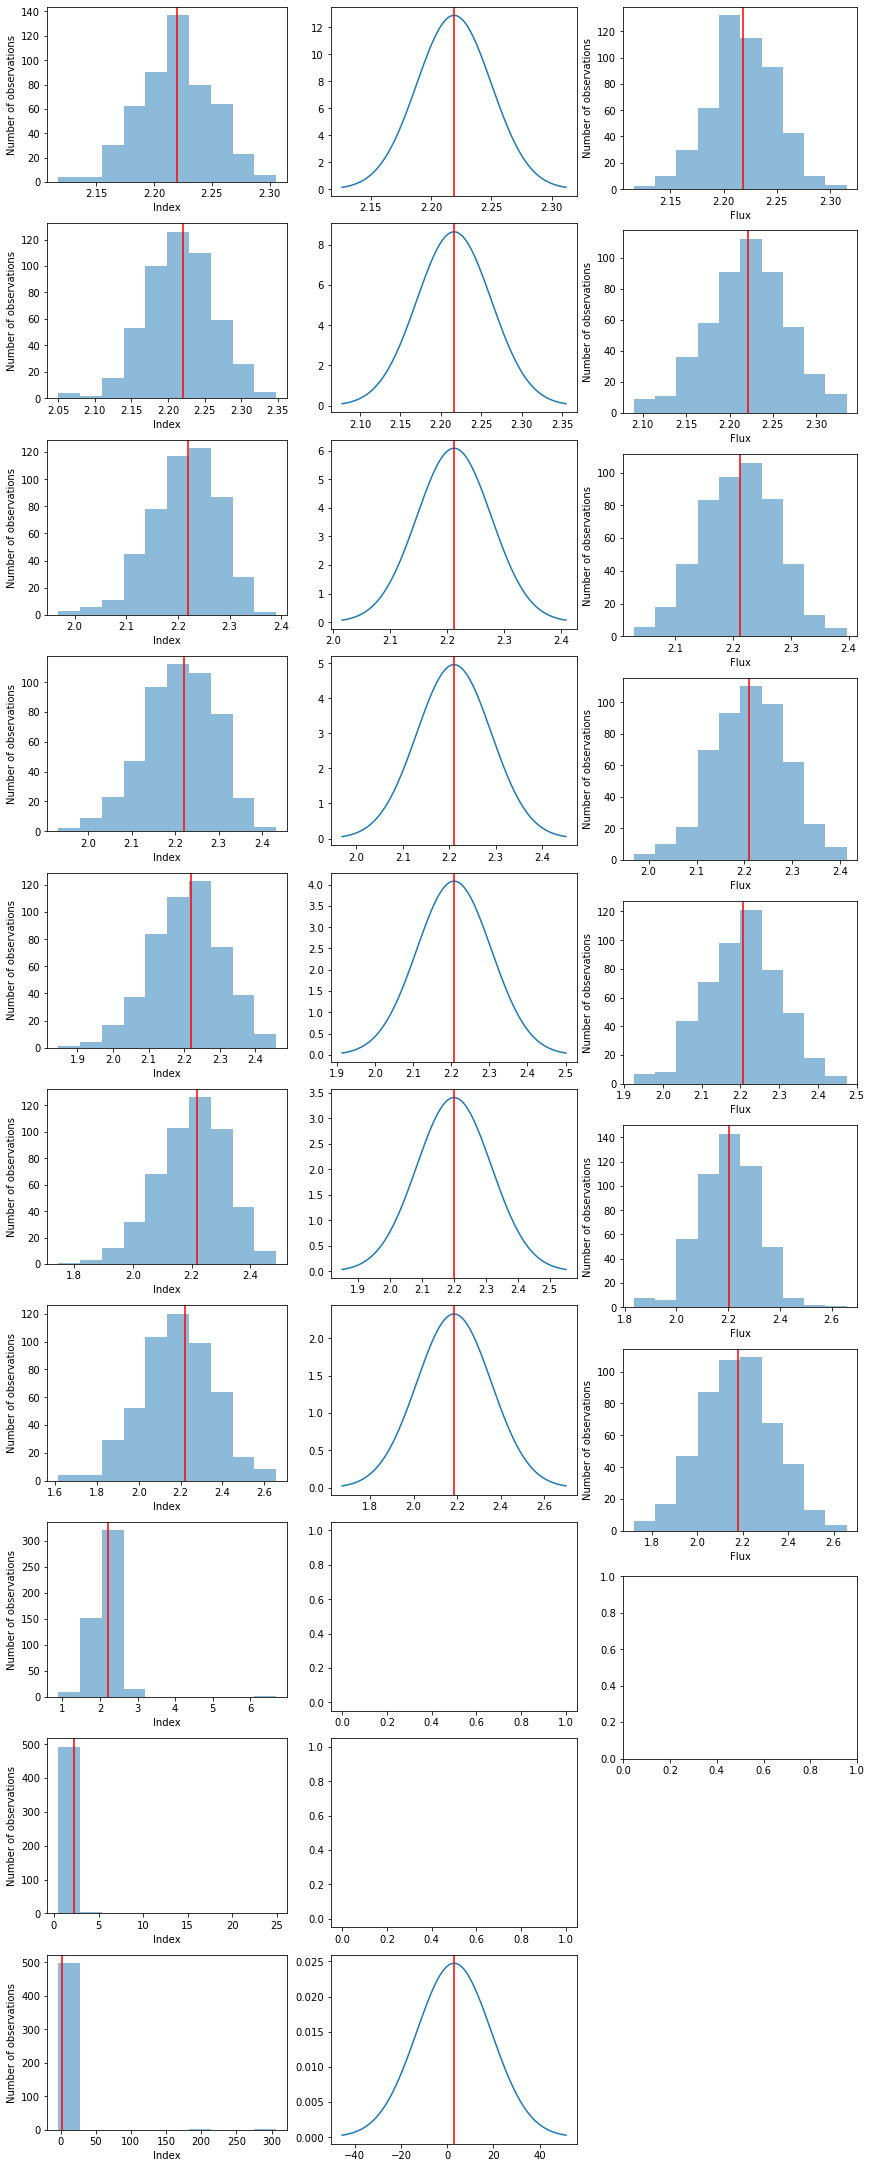

In [19]:
fig = plt.figure(figsize=[16,30],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 4, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[0])
for n in range(1):
    ax = fig.add_subplot(gs1[n])
    plt.hist(index[n], bins=10, alpha=0.5)
    plt.axvline(x=model_simu.parameters["index"].value, color="red")
    plt.xlabel("Index")
    plt.ylabel("Number of observations")
    print(f"index: {index[n].mean()} += {index[n].std()}")
    
for n in range(9):
    ax = fig.add_subplot(gs1[n+1])
    plt.hist(index[n+1], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["index"].value, color="red")
    plt.xlabel("Index")
    plt.ylabel("Number of observations")
    print(f"index: {index[n+1].mean()} += {index[n+1].std()}")
    
gs2 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[1])
for n in range(10):
    ax = fig.add_subplot(gs2[n])
    mu[n] = index[n].mean()
    sigma[n] = index[n].std()
    x = np.linspace(mu[n] - 3*sigma[n], mu[n] + 3*sigma[n], n_obs)
    plt.plot(x, stats.norm.pdf(x, mu[n], sigma[n]))
    plt.axvline(x=mu[n], color="red")

gs3 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[2])
for n in range(10):
    ax = fig.add_subplot(gs3[n])
    np_hist[n] = np.random.normal(loc=mu[n], scale=sigma[n], size=n_obs)
    mu[n] = np_hist[n].mean()
    sigma[n] = np_hist[n].std()
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.axvline(x=mu[n], color="red")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    
gs4 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[3])
for n in range(1):
    ax = fig.add_subplot(gs4[n])
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.hist(index[n], bins=10, alpha=0.5)
    plt.axvline(x=model_simu.parameters["index"].value, color="green")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    
for n in range(9):
    ax = fig.add_subplot(gs4[n+1])
    plt.hist(x=np_hist[n+1], bins=10, alpha=0.5)
    plt.hist(index[n+1], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["index"].value, color="green")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    

plt.show()

In [ ]:
fig = plt.figure(figsize=[16,30],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 4, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[0])
for n in range(1):
    ax = fig.add_subplot(gs1[n])
    plt.hist(amplitude[n], bins=10, alpha=0.5)
    plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
    plt.xlabel("amplitude")
    plt.ylabel("Number of observations")
    print(f"amplitude: {amplitude[n].mean()} += {amplitude[n].std()}")
    
for n in range(9):
    ax = fig.add_subplot(gs1[n+1])
    plt.hist(amplitude[n+1], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["amplitude"].value, color="red")
    plt.xlabel("amplitude")
    plt.ylabel("Number of observations")
    print(f"amplitude: {amplitude[n+1].mean()} += {amplitude[n+1].std()}")
    
gs2 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[1])
for n in range(10):
    ax = fig.add_subplot(gs2[n])
    mu[n] = amplitude[n].mean()
    sigma[n] = amplitude[n].std()
    x = np.linspace(mu[n] - 3*sigma[n], mu[n] + 3*sigma[n], n_obs)
    plt.plot(x, stats.norm.pdf(x, mu[n], sigma[n]))
    plt.axvline(x=mu[n], color="red")

gs3 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[2])
for n in range(10):
    ax = fig.add_subplot(gs3[n])
    np_hist[n] = np.random.normal(loc=mu[n], scale=sigma[n], size=n_obs)
    mu[n] = np_hist[n].mean()
    sigma[n] = np_hist[n].std()
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.axvline(x=mu[n], color="red")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    
gs4 = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs0[3])
for n in range(1):
    ax = fig.add_subplot(gs4[n])
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.hist(amplitude[n], bins=10, alpha=0.5)
    plt.axvline(x=model_simu.parameters["amplitude"].value, color="green")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    
for n in range(9):
    ax = fig.add_subplot(gs4[n+1])
    plt.hist(x=np_hist[n+1], bins=10, alpha=0.5)
    plt.hist(amplitude[n+1], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["amplitude"].value, color="green")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    

plt.show()

In [ ]:
fig = plt.figure(figsize=[16,30],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 4, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(9, 1, subplot_spec=gs0[0])
for n in range(9):
    ax = fig.add_subplot(gs1[n])
    plt.hist(lambda_[n], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["lambda_"].value, color="red")
    plt.xlabel("lambda_")
    plt.ylabel("Number of observations")
    print(f"lambda_: {lambda_[n].mean()} += {lambda_[n].std()}")
    
gs2 = gridspec.GridSpecFromSubplotSpec(9, 1, subplot_spec=gs0[1])
for n in range(9):
    ax = fig.add_subplot(gs2[n])
    mu[n] = lambda_[n].mean()
    sigma[n] = lambda_[n].std()
    x = np.linspace(mu[n] - 3*sigma[n], mu[n] + 3*sigma[n], n_obs)
    plt.plot(x, stats.norm.pdf(x, mu[n], sigma[n]))
    plt.axvline(x=mu[n], color="red")

gs3 = gridspec.GridSpecFromSubplotSpec(9, 1, subplot_spec=gs0[2])
for n in range(9):
    ax = fig.add_subplot(gs3[n])
    np_hist[n] = np.random.normal(loc=mu[n], scale=sigma[n], size=n_obs)
    mu[n] = np_hist[n].mean()
    sigma[n] = np_hist[n].std()
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.axvline(x=mu[n], color="red")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    
gs4 = gridspec.GridSpecFromSubplotSpec(9, 1, subplot_spec=gs0[3])    
for n in range(9):
    ax = fig.add_subplot(gs4[n])
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.hist(lambda_[n], bins=10, alpha=0.5)
    plt.axvline(x=simu[n].parameters["lambda_"].value, color="green")
    plt.xlabel('Flux')
    plt.ylabel('Number of observations')
    

plt.show()

In [ ]:
sim = [] 
s = PowerLawSpectralModel(
    index=index[0].mean(),
    amplitude=amplitude[0].mean() * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
print(s)
sim.append(s)

for i in range(9):
    s = ExpCutoffPowerLawSpectralModel(
        index=index[i+1].mean(),
        amplitude=amplitude[i+1].mean() * u.Unit("cm-2 s-1 TeV-1"),
        reference=1 * u.TeV,
        lambda_=lambda_[i].mean() * u.Unit("TeV-1"),
        alpha = 1,
    )
    print(s)
    sim.append(s)

In [ ]:
plt.figure(figsize=[16,8])
energy_range = [0.03, 100] * u.TeV
sim[0].plot(energy_range)
for i in range(9):
    sim[i+1].plot(energy_range)
plt.show

In [ ]:
fig = plt.figure(figsize=[16,8],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 3, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0])
for n in range(3):
    ax = fig.add_subplot(gs1[n])
    sim[0].plot(energy_range)
    sim[n+1].plot(energy_range)

gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[1])
for n in range(3):
    ax = fig.add_subplot(gs2[n])
    sim[0].plot(energy_range)
    sim[n+4].plot(energy_range)

gs3 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[2])
for n in range(3):
    ax = fig.add_subplot(gs3[n])
    sim[0].plot(energy_range)
    sim[n+7].plot(energy_range)
    
plt.show()

In [ ]:
def evaluate_err(self, covar, energy, epsilon=1e-4):

        p_cov = covar
        eps = np.sqrt(np.diag(covar)) * epsilon

        df_dp = self._evaluate_gradient(energy, eps)
        f_cov = df_dp.T @ p_cov @ df_dp
        f_err = np.sqrt(np.diagonal(f_cov))

        q = self(energy)
        return u.Quantity([q.value, f_err], unit=q.unit)

In [ ]:
def plot_error(
        self,
        covar,
        energy_range,
        ax=None,
        energy_unit="TeV",
        flux_unit="cm-2 s-1 TeV-1",
        energy_power=0,
        n_points=100,
        **kwargs,
    ):
        
        ax = plt.gca() if ax is None else ax

        kwargs.setdefault("facecolor", "black")
        kwargs.setdefault("alpha", 0.2)
        kwargs.setdefault("linewidth", 0)

        emin, emax = energy_range
        energy = MapAxis.from_energy_bounds(emin, emax, n_points, energy_unit).edges

        flux, flux_err = evaluate_err(self,covar,energy).to(flux_unit)

        y_lo = self._plot_scale_flux(energy, flux - flux_err, energy_power)
        y_hi = self._plot_scale_flux(energy, flux + flux_err, energy_power)

        where = (energy >= energy_range[0]) & (energy <= energy_range[1])
        ax.fill_between(energy.value, y_lo.value, y_hi.value, where=where, **kwargs)

        self._plot_format_ax(ax, energy, y_lo, energy_power)
        return ax

In [ ]:
fig = plt.figure(figsize=[16,16],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 3, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0])
for n in range(3):
    ax = fig.add_subplot(gs1[n])
    sim[0].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[0], covar=covar[0],energy_range=energy_range, energy_power=2)
    sim[n+1].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[n+1], covar=covar[n+1],energy_range=energy_range, energy_power=2)

gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[1])
for n in range(3):
    ax = fig.add_subplot(gs2[n])
    sim[0].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[0], covar=covar[0],energy_range=energy_range, energy_power=2)
    sim[n+4].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[n+4], covar=covar[n+4],energy_range=energy_range, energy_power=2)

gs3 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[2])
for n in range(3):
    ax = fig.add_subplot(gs3[n])
    sim[0].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[0], covar=covar[0],energy_range=energy_range, energy_power=2)
    sim[n+7].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[n+7], covar=covar[n+7],energy_range=energy_range, energy_power=2)
    
plt.show()